# Question 2.1
#### For solving the Classification problem we have used Convolutional Neural Network (CNN). In the design used to solve this problem there are 3 Convolution layer with kernel size of (3,3). In addition to Convolutional layer there are two layer of Max Pooling that is used in conjunction with the Convolutional layer. After this the output data is flattened before passing it to the Feed Forward Neural Network. In the Feed Forward Neural Network there are three layers. The First layer has 64 Neurons and in the second layer there 32 units. The final layer of the Neural Network has 3 Neurons for the Class labels and the activation function used Softmax. This is the architecture used for Chest diesease Image Classification. 


# Question 2.2

In [1]:
# Import Necessary Packages 
import pathlib
import timeit
import cv2
import sys 
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow.keras import layers, models 
from keras.utils import to_categorical
from sklearn import svm 
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


In [2]:
class ChestDiseaseClassification(object):
    """ Class For Chest Image Classification using CNN Neural Network
    Parameter: 
    -----------
    Normal_TrainImage_path: Path of Train folder for Normal Chest Images 
    Pneumonia_TrainImage_path: Path of Train folder for Pneumonia Chest Images 
    TB_TrainImage_path: Path of Train folder for TB Chest Images 
    epochs: Number of Epochs required for Training the Network 
    batch_size: Size of each batch required for Training the Network 

    Attributes: 
    ------------
    self 
    """

    def __init__(self, Normal_TrainImage_path, Pneumonia_TrainImage_path,
                 TB_TrainImage_path, TestImage_path, epochs = 10, batch_size = 16):

        self.epochs = epochs 
        self.batch_size = batch_size 
        self.Normal_TrainImage_path = Normal_TrainImage_path
        self.Pneumonia_TrainImage_path = Pneumonia_TrainImage_path
        self.TB_TrainImage_path = TB_TrainImage_path
        self.TestImage_path = TestImage_path

        self.train_data = []
        self.train_labels = []
   
    def Convert_Preprocess_train(self, path, label):
        """ Convert the dataset in the required Format 
        Parameter: 
        -----------
        path: Path with all images 
        label: Labes/Target Requried for the Image   

        Attributes:
        ------------
        self.train_data: Processed Train Data 
        self.train_labels: Processed Train Labels as per images in the Train dataset
        """

        for image in path:
 
            image = cv2.imread(str(image))  
            image = cv2.resize(image, (224, 224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(np.float32)/255.
            self.train_data.append(image)
            self.train_labels.append(label)
    
        return self.train_data, self.train_labels 

    def Convert_Preprocess_test(self, path):
        """ Convert the dataset in the required Format 
        Parameters: 
        ------------
        path: Path for the Test Dataset 

        Attributes: 
        ------------
        data_list: list of Test dataset
        """
        data_list = []

        for image in path:
 
            image = cv2.imread(str(image))  
            image = cv2.resize(image, (224, 224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(np.float32)/255.
            data_list.append(image)
    
        return data_list 

    def Load_Data(self):
        """ Data Load Function for Neural Network  
        Parameter: 
        -----------
        self

        Attributes: 
        ------------
        train_data_arr: Train Data for Neural Networks 
        test_data_arr: Test Data for Neural Networks 
        train_labels_arr: Labels/Target of Train set 
        """

        # Load Normal Train Dataset into the Train data list
        Normal_TrainDir_path = pathlib.Path(self.Normal_TrainImage_path)
        normal_image_path = Normal_TrainDir_path.glob('*.jpg')
        label_normal = 0 
        normal_data, normal_labels = self.Convert_Preprocess_train(normal_image_path, label_normal)


        # Pneumonia Train Data 
        Pneumonia_TrainDir_path = pathlib.Path(self.Pneumonia_TrainImage_path)
        pneumonia_image_path = Pneumonia_TrainDir_path.glob('*.jpg')
        label_pneumonia = 1 
        pneumonia_data, pneumonia_labels = self.Convert_Preprocess_train(pneumonia_image_path, label_pneumonia)


        # TB Train Data 
        TB_TrainDir_path = pathlib.Path(self.TB_TrainImage_path)
        tb_image_path = TB_TrainDir_path.glob('*.jpg')
        label_tb = 2 
        tb_data, tb_labels = self.Convert_Preprocess_train(tb_image_path, label_tb)


        # Test Data 
        TestDir_path = pathlib.Path(self.TestImage_path)
        test_path = TestDir_path.glob('*.jpg')
        label_normal = 0 
        test_data = self.Convert_Preprocess_test(test_path)

        # Convert list to Numpy array 
        train_data_arr = np.array(self.train_data)
        train_labels_arr = np.array(self.train_labels)
        test_data_arr = np.array(test_data)

        return train_data_arr, test_data_arr, train_labels_arr 

    def CNN_Model(self): 
        """ CNN Model Initialization Function 
        Parameters:
        ------------
        self
        
        Attributes: 
        self 
        """

        self.model = models.Sequential()
        self.model.add(layers.Conv2D(64, (3,3), activation='relu',padding='same', input_shape = (224, 224, 3)))
        self.model.add(layers.Conv2D(64, (3,3), activation= 'relu', padding='same'))
        self.model.add(layers.MaxPooling2D((2,2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.model.add(layers.MaxPooling2D((2,2)))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(64, activation = 'relu'))
        self.model.add(layers.Dense(32, activation = 'relu'))
        self.model.add(layers.Dense(3, activation = 'softmax'))

        self.model.summary()

        return self 
    
    def train_CNN(self, X_train, y_train, X_val, y_val): 
        """ Train Function for CNN 
        Parameters: 
        ------------
        X_train: Train Data for the Model 
        y_train: Train Labels/Targets for the Model 
        X_val: Validation Set for the Model 
        y_val: Validation Labels/Targets for the Model 

        Attributes:
        ------------
        history: History of the Model 
        self.Model: Neural Network Model 
        """
        self.CNN_Model()
        self.model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
        history = self.model.fit(X_train, y_train, batch_size = self.batch_size, epochs = self.epochs, validation_data = (X_val, y_val))

        return history, self.model  
    
    def Model_loss_Evaluation(self, history_model, model_eva):
        """ Loss Plot for Model 
        Parameter: 
        -----------
        history_model: history of the model 
        model_eva: Name of the Model 

        """
        plt.plot(history_model.history['loss'], color = 'm', label = 'Training Loss')
        plt.plot(history_model.history['val_loss'], color = 'r', label = "Val Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Model Evaluation for {0}'.format(model_eva))
        plt.legend(loc = 'best')
        plt.show()

    def Model_Accuracy_Evaluation(self, history_model, model_eva):
        """ Accracy Plot for the Model
        Parameter: 
        -----------
        history_model: history for the model 
        model_eva: Name of the Model   
        """
        plt.plot(history_model.history['accuracy'], color = 'k', label = " Accuracy ")
        plt.plot(history_model.history['val_accuracy'], color = 'g', label = 'Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Score ')
        plt.title('Model Accuracy Evaluation for {0}'.format(model_eva))
        plt.legend(loc = 'best')
        plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Path for the Folder 
Normal_Train_imagedir = '/content/drive/My Drive/Dataset/Dataset/train/Normal'
Pneumonia_Train_imagedir = '/content/drive/My Drive/Dataset/Dataset/train/Pneumonia'
TB_Train_imagedir = '/content/drive/My Drive/Dataset/Dataset/train/TB'
Test_imagedir = '/content/drive/My Drive/Dataset/Dataset/test'


In [5]:
# Initialize the Class 
cic = ChestDiseaseClassification(Normal_Train_imagedir, Pneumonia_Train_imagedir, TB_Train_imagedir, Test_imagedir, epochs = 15, batch_size=14)

In [6]:
# Load the Dataset 
data_train, data_test, train_labels = cic.Load_Data()

# Check the Train and Test Dataset
print("Shape of X_train Set: ", data_train.shape)
print("Shape of y_train set: ", train_labels.shape)
print("Shape of X_test Set: ", data_test.shape)

Shape of X_train Set:  (251, 224, 224, 3)
Shape of y_train set:  (251,)
Shape of X_test Set:  (66, 224, 224, 3)


In [7]:
# Split the Dataset in 70:30 ratio 
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(data_train, train_labels, test_size = 0.30, random_state = 42)

In [8]:
# Train the Model 
start = timeit.default_timer()
history, model = cic.train_CNN(X_train_nn, y_train_nn, X_val_nn, y_val_nn)
stop = timeit.default_timer()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 193600)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [9]:
sys.stderr.write(" \n Complete Training Time for CNN on Training Set is {0} Seconds".format(stop - start))
sys.stderr.flush()

 
 Complete Training Time for CNN on Training Set is 13.074184321999837 Seconds

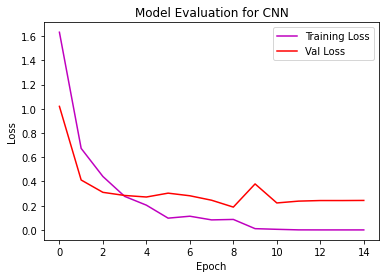

In [10]:
# Plot for Loss for the Model 
cic.Model_loss_Evaluation(history, model_eva = 'CNN')

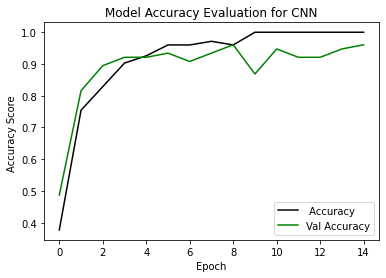

In [11]:
# Plot for Accucracy Score for the Model 
cic.Model_Accuracy_Evaluation(history, model_eva = 'CNN')

In [12]:
# Shape of the Test Dataset 
print("Shape of the Test Dataset: ",data_test.shape)

Shape of the Test Dataset:  (66, 224, 224, 3)


In [13]:
# Predict the Labels for the Test Set   
start = timeit.default_timer()
y_pred = model.predict(data_test)
stop = timeit.default_timer()
sys.stderr.write(" \n Prediction Time for CNN on Test Set is {0} Seconds".format(stop - start))
sys.stderr.flush()

 
 Prediction Time for CNN on Test Set is 0.4973570069998914 Seconds

In [14]:
# Get the Lables for the Test Set 
start = timeit.default_timer()
y_pred_classes = model.predict_classes(data_test)
stop = timeit.default_timer()
sys.stderr.write(" \n Classes Prediction Time for CNN on Test Set is {0} Seconds".format(stop - start))
sys.stderr.flush()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


 
 Classes Prediction Time for CNN on Test Set is 0.09791132299983474 Seconds

In [15]:
# Print the Class Labels of Test Set 
print("Predicted Class Labels from the Neural Network on the Test Set: ",y_pred_classes)

Predicted Class Labels from the Neural Network on the Test Set:  [2 2 1 0 2 0 2 1 0 1 2 0 0 2 1 0 1 1 1 0 2 0 2 1 0 0 0 2 2 2 2 0 2 2 1 0 1
 1 1 2 1 2 2 2 0 2 1 2 0 2 1 1 2 1 1 2 2 0 1 1 0 2 0 2 1 1]


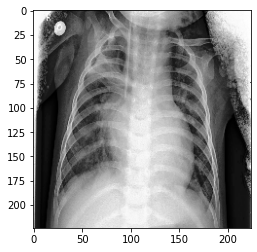

In [19]:
# Show the Image for Verification 
plt.imshow(data_test[62])